In [1]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
import xgboost
import shap
import numpy as np
shap.initjs()

all_runs = pd.read_csv('../logs-summary.csv')

# Rajoute des informations extraites du nom des runs.
def parse_filename(filename):
    if filename.strip().startswith('/home/local/mickus/talking-lizards/'):
        filename = filename.strip()[len('/home/local/mickus/talking-lizards/'):]
    components = filename.split('/')
    run_dir, exp_set, *setup, run_no, date, zero, events_fname = components

    setup = ' '.join(setup[::-1])
    
    return {
        'run no': int(run_no),
        'setup': setup,
        'difficulty strategy': (exp_set == 'exp1.5'),
    }

parsed_filenames = all_runs['event_file'].apply(parse_filename)
all_runs['run no'] = parsed_filenames.apply(lambda d: d['run no'])
all_runs['setup'] = parsed_filenames.apply(lambda d: d['setup'])
all_runs['difficulty strategy'] = parsed_filenames.apply(lambda d: d['difficulty strategy'])

# Filtrage des runs ; on cherche à ne garder que ceux ayant appris.
threshold = (60 / 100)
successful_runs = all_runs[all_runs['eval/success_rate from 0 (max)'] >= threshold]
successful_runs

/usr/lib/python3/dist-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/lib/python3/dist-packages/dask/dataframe/utils.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/lib/python3/dist-packages/dask/dataframe/utils.py:362: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/lib/python3/dist-packages/dask/dataframe/utils.py:362: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _

,event_file,eval/scrambling-resistance from 0 (min),eval/scrambling-resistance from 0 (max),eval/scrambling-resistance from 0 (mean),eval/scrambling-resistance from 0 (median),eval/scrambling-resistance from 0 (std),eval/scrambling-resistance from 50 (min),eval/scrambling-resistance from 50 (max),eval/scrambling-resistance from 50 (mean),eval/scrambling-resistance from 50 (median),...,ALT eval/accuracy-eval-d from 50 (median),ALT eval/accuracy-eval-d from 50 (std),ALT eval/accuracy-eval-d from 75 (min),ALT eval/accuracy-eval-d from 75 (max),ALT eval/accuracy-eval-d from 75 (mean),ALT eval/accuracy-eval-d from 75 (median),ALT eval/accuracy-eval-d from 75 (std),run no,setup,difficulty strategy
0,/home/local/mickus/talking-lizards/runs/exp1.5...,0.856353,0.999999,0.907405,0.908304,0.024967,0.865993,0.944452,0.904660,0.903158,...,2.539200,0.049377,2.472007,2.637778,2.535166,2.529143,0.039874,10,frozen category-wise,True
1,/home/local/mickus/talking-lizards/runs/exp1.5...,0.897155,1.000000,0.929516,0.929958,0.016241,0.897155,0.950009,0.918644,0.915864,...,3.451670,0.185064,3.361049,3.640171,3.509509,3.520828,0.081161,4,frozen category-wise,True
2,/home/local/mickus/talking-lizards/runs/exp1.5...,0.901639,0.992834,0.932689,0.931172,0.015970,0.907729,0.963201,0.931508,0.929719,...,2.269952,0.100146,2.193559,2.752751,2.309608,2.262821,0.128170,1,frozen category-wise,True
3,/home/local/mickus/talking-lizards/runs/exp1.5...,0.832702,0.999996,0.867598,0.859324,0.030809,0.833781,0.865802,0.854998,0.855646,...,3.024468,0.166977,2.929886,3.314920,3.166275,3.171549,0.086196,6,frozen category-wise,True
4,/home/local/mickus/talking-lizards/runs/exp1.5...,0.846768,1.000000,0.881252,0.877687,0.022584,0.862032,0.899766,0.881393,0.880999,...,2.836800,0.072585,2.739026,2.968593,2.829678,2.830494,0.051679,3,frozen category-wise,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1115,/home/local/mickus/talking-lizards/runs/exp1/B...,0.871912,1.000000,0.901845,0.890420,0.032566,0.871912,0.898555,0.886576,0.886794,...,3.299503,0.075700,3.171856,3.429240,3.299141,3.294847,0.073977,9,B,False
1116,/home/local/mickus/talking-lizards/runs/exp1/B...,0.861081,1.000000,0.901393,0.890280,0.028898,0.862834,0.907135,0.886317,0.886840,...,2.763121,0.061626,2.711668,2.851962,2.775635,2.772767,0.040998,2,B,False
1117,/home/local/mickus/talking-lizards/runs/exp1/B...,0.856809,1.000000,0.912754,0.897344,0.042443,0.856809,0.923779,0.893047,0.894430,...,2.720347,0.045852,2.663161,2.826508,2.732511,2.725855,0.046575,5,B,False
1118,/home/local/mickus/talking-lizards/runs/exp1/B...,0.824167,1.000000,0.883080,0.876616,0.031633,0.859937,0.897938,0.880234,0.881425,...,3.116372,0.078874,2.884301,3.260122,3.118295,3.132357,0.079129,8,B,False


In [2]:
# les stats par groupe peuvent aussi se calculer directement sur l'objet `groupBy`
keys = [
    'eval/success_rate from 0 (max)', 
    'eval/scrambling-resistance from 75 (max)', 
    'FM_corr/Jaccard-based comp from 75 (max)', 
    'FM_corr/Normalised Lev-based comp from 75 (max)', 
    'ALT eval/success_rate from 0 (max)'
]
indices = ['setup', 'difficulty strategy']
means = successful_runs[[*indices, *keys]].groupby(by=indices).mean()
stds = successful_runs[[*indices, *keys]].groupby(by=indices).std()
experiments = pd.DataFrame({
  'convergence': (successful_runs[indices].groupby(by=indices).size() / all_runs[indices].groupby(by=indices).size()),
  **{f'[mean] {key}': means[key] for key in keys},
  **{f'[std] {key}': stds[key] for key in keys},
}).reset_index()
experiments['convergence'].fillna(0.0, inplace=True)

#experiments.insert(4, f"[mean; alt-space] {keys[0]}", experiments[f"[mean] {keys[0]}"].apply(lambda x: -np.log(1.0 - x))) # Ici on transforme la mean, alors que la mean de la transformée serait peut-être plus appropriée.

experiments

,setup,difficulty strategy,convergence,[mean] eval/success_rate from 0 (max),[mean] eval/scrambling-resistance from 75 (max),[mean] FM_corr/Jaccard-based comp from 75 (max),[mean] FM_corr/Normalised Lev-based comp from 75 (max),[mean] ALT eval/success_rate from 0 (max),[std] eval/success_rate from 0 (max),[std] eval/scrambling-resistance from 75 (max),[std] FM_corr/Jaccard-based comp from 75 (max),[std] FM_corr/Normalised Lev-based comp from 75 (max),[std] ALT eval/success_rate from 0 (max)
0,B,False,1.0,0.960278,0.906500,0.395623,0.346797,3.273785,0.013276,0.014396,0.107419,0.123228,0.322232
1,B,True,1.0,0.982019,0.917719,0.414249,0.346527,4.035442,0.003466,0.030257,0.085893,0.091866,0.195167
2,E,False,0.8,0.940826,0.907181,0.431183,0.399332,2.851593,0.014853,0.026800,0.097519,0.108912,0.229373
3,E,True,0.7,0.967721,0.919497,0.379237,0.341958,3.473513,0.009877,0.044762,0.089714,0.100198,0.306782
4,E+B,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,thawed feature-wise+E+H+B,True,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,thawed feature-wise+H,False,1.0,0.944153,0.908596,0.452509,0.414495,2.915345,0.013657,0.028790,0.076754,0.093956,0.269729
109,thawed feature-wise+H,True,1.0,0.969238,0.920376,0.346953,0.300133,3.604284,0.015082,0.010491,0.063564,0.071837,0.535349
110,thawed feature-wise+H+B,False,1.0,0.961487,0.924362,0.439426,0.408594,3.326976,0.014550,0.016306,0.054386,0.067175,0.404392


In [3]:
def infer_setup_runwise_success(row):

    def lookup(keyword):
        return int(keyword in row['setup'])

    cvg = experiments[(experiments['setup'] == row['setup'])  & (experiments['difficulty strategy'] == row['difficulty strategy'])].convergence.to_list()
    assert len(cvg) == 1, cvg
    cvg = cvg[0]
    
    record = {
        'DV': row['ALT eval/success_rate from 0 (max)'],
        'S': int(row['difficulty strategy']),
        'F': lookup('frozen'),
        'CW': lookup('category-wise'),
        'FW': lookup('feature-wise'),
        'AE': lookup('auto-encoder'),
        'E': lookup('E'),
        'H': lookup('H'),
        'B': lookup('B'),
        'cvg': cvg
    }

    return record


def infer_setup_expwise_success(row):

    def lookup(keyword):
        return int(keyword in row['setup'])

    cvg = experiments[(experiments['setup'] == row['setup'])  & (experiments['difficulty strategy'] == row['difficulty strategy'])].convergence.to_list()
    assert len(cvg) == 1, cvg
    cvg = cvg[0]
    
    record = {
        'DV': row['[mean] ALT eval/success_rate from 0 (max)'],
        'S': int(row['difficulty strategy']),
        'F': lookup('frozen'),
        'CW': lookup('category-wise'),
        'FW': lookup('feature-wise'),
        'AE': lookup('auto-encoder'),
        'E': lookup('E'),
        'H': lookup('H'),
        'B': lookup('B'),
        'cvg': cvg
    }

    return record


def infer_setup_runwise_lev(row):

    def lookup(keyword):
        return int(keyword in row['setup'])

    cvg = experiments[(experiments['setup'] == row['setup'])  & (experiments['difficulty strategy'] == row['difficulty strategy'])].convergence.to_list()
    assert len(cvg) == 1, cvg
    cvg = cvg[0]
    
    record = {
        'DV': row['FM_corr/Normalised Lev-based comp from 75 (max)'],
        'S': int(row['difficulty strategy']),
        'F': lookup('frozen'),
        'CW': lookup('category-wise'),
        'FW': lookup('feature-wise'),
        'AE': lookup('auto-encoder'),
        'E': lookup('E'),
        'H': lookup('H'),
        'B': lookup('B'),
        'cvg': cvg
    }

    return record


def infer_setup_expwise_lev(row):

    def lookup(keyword):
        return int(keyword in row['setup'])

    cvg = experiments[(experiments['setup'] == row['setup'])  & (experiments['difficulty strategy'] == row['difficulty strategy'])].convergence.to_list()
    assert len(cvg) == 1, cvg
    cvg = cvg[0]
    
    record = {
        'DV': row['[mean] FM_corr/Normalised Lev-based comp from 75 (max)'],
        'S': int(row['difficulty strategy']),
        'F': lookup('frozen'),
        'CW': lookup('category-wise'),
        'FW': lookup('feature-wise'),
        'AE': lookup('auto-encoder'),
        'E': lookup('E'),
        'H': lookup('H'),
        'B': lookup('B'),
        'cvg': cvg
    }

    return record

In [4]:
runs_lev = pd.DataFrame.from_records(successful_runs.apply(infer_setup_runwise_lev, axis=1))
runs_suc = pd.DataFrame.from_records(successful_runs.apply(infer_setup_runwise_success, axis=1))

converged_exps = experiments[experiments.convergence > 0.0]
exps_lev = pd.DataFrame.from_records(converged_exps.apply(infer_setup_expwise_lev, axis=1))
exps_suc = pd.DataFrame.from_records(converged_exps.apply(infer_setup_expwise_success, axis=1))

In [5]:
y = runs_lev.DV
X = runs_lev.drop('DV', axis=1)

In [6]:
sample_ind=10

X100 = shap.utils.sample(X, 100)

model = CatBoostRegressor(iterations=300, learning_rate=0.1, random_seed=123)
cat_features = list(range(0, X.shape[1] - 1))
model.fit(X, y, cat_features=cat_features, verbose=False, plot=False)
model.set_feature_names(X.columns)

explainer = shap.TreeExplainer(model, feature_names=X.columns)
shap_values = explainer.shap_values(Pool(X, y, cat_features=cat_features))

In [7]:
model.get_feature_importance(data=Pool(X, y, cat_features=cat_features))  

array([21.15212165, 25.67308188,  9.93225445,  5.0828186 ,  5.67127786,
        8.07026617,  9.99548836, 11.06453346,  3.35815757])

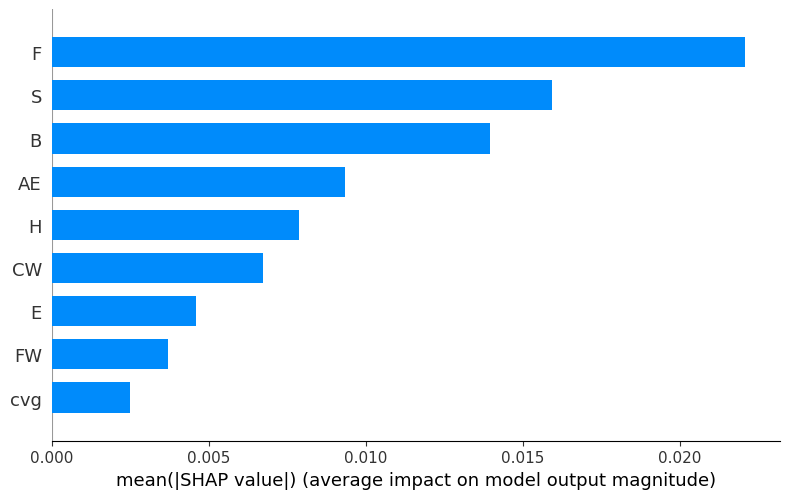

In [8]:
shap.summary_plot(shap_values, plot_type='bar', feature_names=X.columns)

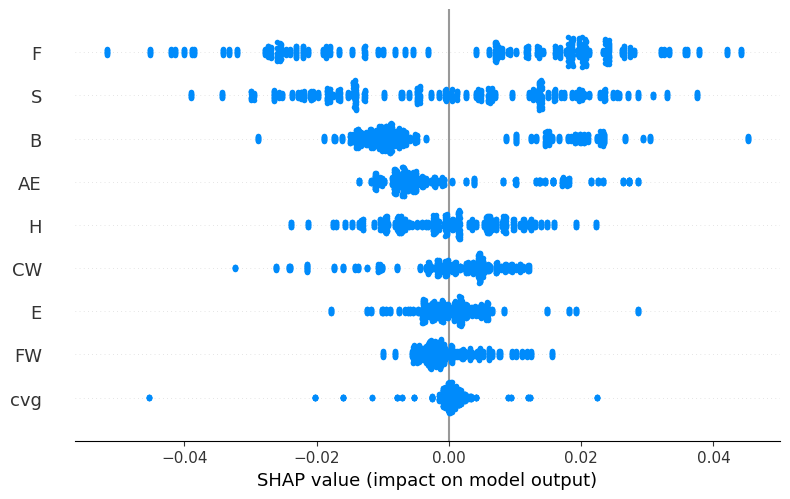

In [9]:
shap.summary_plot(shap_values, feature_names=X.columns) 

Exact explainer: 806it [00:19, 27.21it/s]                                                            


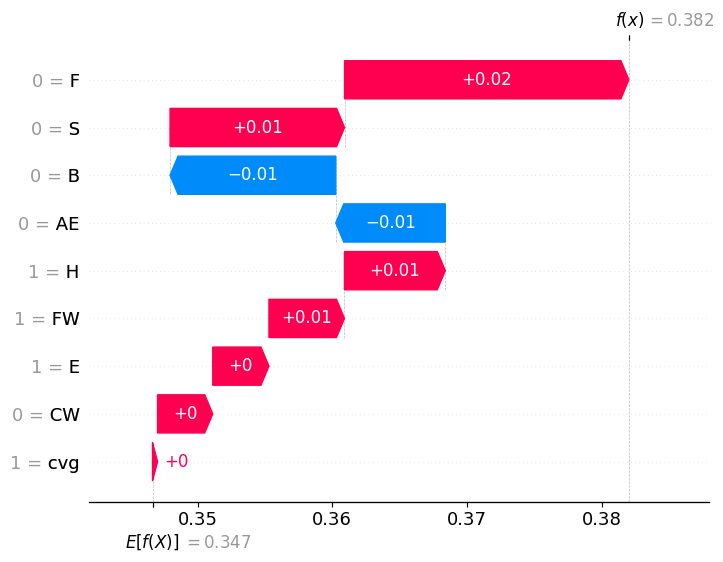

In [10]:
model = xgboost.XGBRegressor(max_depth=1).fit(X, y)
explainer = shap.Explainer(model.predict, X)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[y.argmax()])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


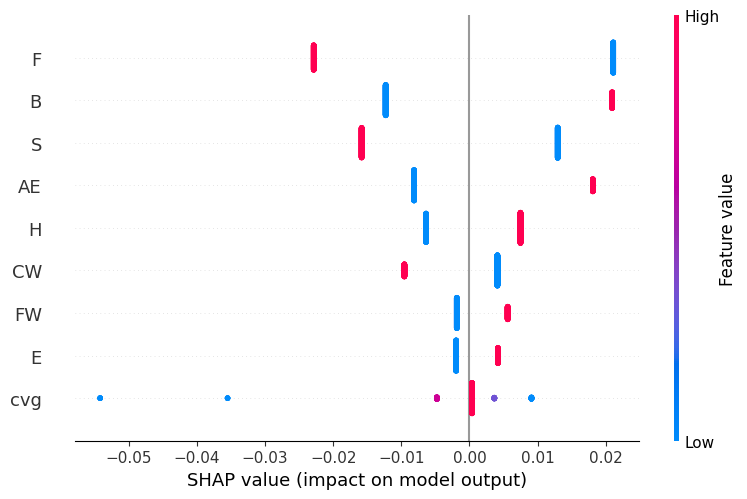

In [11]:
shap.summary_plot(shap_values)

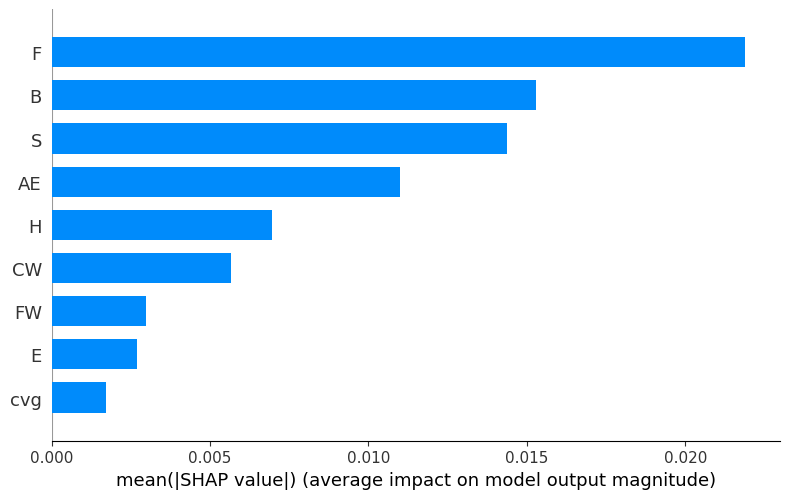

In [12]:
shap.summary_plot(shap_values, plot_type='bar')